In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 10]


import torch
from torch.utils.data import Dataset
from retinanet.encoder import DataEncoder
import imgaug as ia
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss
from utils.pikachu_dataset import load_data_pikachu


/home/i008/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

class PikachuDataset(Dataset):
    def __init__(self, anchor_areas=None):
        
        self.anchor_areas = anchor_areas
        self.train, self.val = load_data_pikachu(1)
    
        encoder = DataEncoder()
        if self.anchor_areas is not None:
            encoder.anchor_areas = self.anchor_areas  # p3 -> p7
            
        self.encoder = encoder 
        
    def __len__(self):
        return 900 #magic number thats how many images are in the pikachu dataset
        
    def __getitem__(self, i):
        try:
            b = self.train.next()
        except StopIteration:
            self.train.reset()
            b = self.train.next()
            
        image = b.data[0].asnumpy()
        bbox = b.label[0].asnumpy()[:, 0, 1:] * 256
        label = b.label[0].asnumpy()[:, 0, 0]
    
        return torch.from_numpy(image), torch.from_numpy(bbox), torch.from_numpy(label)    
    
    def collate_func(self, batch):
    

        images = [b[0][0] for b in batch]
        bbox = [b[1] for b in batch]
        labels = [b[2] for b in batch]
        
        encoded = [self.encoder.encode(bb, l, torch.Tensor([256, 256])) for bb, l in zip(bbox, labels)]
        loc_target = [l[0] for l in encoded]
        cls_target = [l[1] for l in encoded]
        

        return torch.stack(images) / 255, torch.stack(loc_target), torch.stack(cls_target)
        
def init_weights_retina(module, pi=0.02):
    if hasattr(module, 'name'):
        b = -log((1 - pi) / pi)
        if module.name == 'final_layer':
            module.bias.data.fill_(b)
        elif module.name == 'head_layer':
            module.weight.data.normal_(0, pi)
            module.bias.data.fill_(0)
                        

In [3]:
pikachu_ds =PikachuDataset()
pikachu_dl = DataLoader(pikachu_ds, batch_size=8, collate_fn=pikachu_ds.collate_func)


In [4]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RetinaNet(1)
model = model.to(device)


model.freeze_bn()
for param in model.fpn.parameters():
    param.requires_grad = False
    

model.apply(init_weights_retina)

RetinaNet(
  (fpn): FPN(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          

In [5]:
criterion = FocalLoss(1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00004)

collect = []
for epoch in range(5):
    for b in pikachu_dl:
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1)
        optimizer.step()
        collect.append([total_loss])
        print("total loss {}".format(total_loss))
        

/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn

total loss 12752.3984375
total loss 12670.83203125
total loss 12548.0185546875
total loss 12465.0810546875
total loss 12331.740234375
total loss 12167.5556640625
total loss 11985.8212890625
total loss 11782.591796875
total loss 11535.6484375
total loss 11203.3369140625
total loss 10825.7529296875
total loss 10344.45703125
total loss 9679.5634765625
total loss 9377.740234375
total loss 8309.2158203125
total loss 7885.95947265625
total loss 6687.07666015625
total loss 6121.8798828125
total loss 5293.1337890625
total loss 4478.595703125
total loss 3784.264404296875
total loss 3415.099853515625
total loss 2553.265380859375
total loss 2343.4052734375
total loss 1893.44384765625
total loss 1586.6414794921875
total loss 1451.3546142578125
total loss 1148.1004638671875
total loss 1003.7236328125
total loss 1084.21875
total loss 917.3683471679688
total loss 825.6510009765625
total loss 794.9601440429688
total loss 766.3250122070312
total loss 856.6340942382812
total loss 749.8410034179688
total

total loss 81.98978424072266
total loss 61.54570770263672
total loss 102.21484375
total loss 85.83334350585938
total loss 82.21764373779297
total loss 99.85282897949219
total loss 75.3350830078125
total loss 83.3069076538086
total loss 80.83598327636719
total loss 96.5686264038086
total loss 68.46985626220703
total loss 57.19997787475586
total loss 68.27811431884766
total loss 85.61438751220703
total loss 77.54972076416016
total loss 77.83195495605469
total loss 75.37419128417969
total loss 87.68958282470703
total loss 72.91644287109375
total loss 80.30938720703125
total loss 72.73224639892578
total loss 70.92755126953125
total loss 84.6391830444336
total loss 68.38195037841797
total loss 80.53089904785156
total loss 66.74324035644531
total loss 68.35227966308594
total loss 78.95106506347656
total loss 70.60938262939453
total loss 80.354736328125
total loss 75.56525421142578
total loss 79.28845977783203
total loss 66.80007934570312
total loss 68.47331237792969
total loss 76.98238372802

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b5e6eb470>],
      dtype=object)

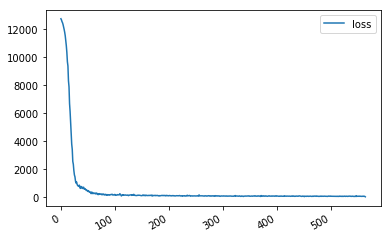

In [6]:
import pandas as pd
pd.DataFrame(collect, columns=['loss']).astype(float).plot(subplots=True)

# Visualizing Results

In [7]:
it = iter(pikachu_dl)


/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


ValueError: only one element tensors can be converted to Python scalars

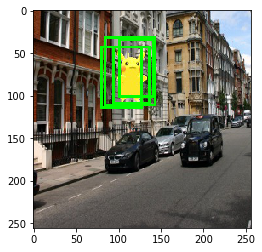

In [8]:
model.eval()
b = next(it)
i = 0
image, bounding_boxes, labels = b
loc_pred, cls_pred = model(image.cuda())


bbspred, labelpred, score  = pikachu_ds.encoder.decode(loc_pred[i].float().cpu(), 
                                                       cls_pred[i].float().cpu(), 
                                                       torch.Tensor([256, 256]).float().cpu()
                                                      )

image_to_show = np.moveaxis(image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))


image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(float(score)))

# Exercises

